In diesem Notebook werden auf verschiedenen Modalitäten verschiedene Modelle trainiert, angewendet und ausgewertet. Jeweils: Random Forest, XGBoost, Logistic Regression, SVM, Neuronales Netz

In [1]:
import pandas as pd
# import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Vorbereitung: Data Split in 3 Datasets!

Preprocessing der Kategorsischen Variablen..

In [7]:
df = pd.read_csv("features_enriched_tab_img_text.csv")
print(df.shape)

df = df.rename(
    columns={
        "stars": "tab_star",
        "year": "tab_year",
        "month": "tab_month",
        "day": "tab_day",
        "likesCount": "tab_likesCount",
        "reviewerNumberOfReviews": "tab_reviewerNumberOfReviews",
        "isLocalGuide": "tab_isLocalGuide",
        "dayofweek": "tab_dayofweek",
        "elapsed_days": "tab_elapsed_days",
        "when_on_day_4hbin": "tab_when_on_day_4hbin",
    }
)

df["label"] = df["label"].replace({"real": 0, "fake": 1})
df["text_sentiment"] = df["text_sentiment"].replace(
    {"negative": 0, "neutral": 1, "positive": 2}
)

df_num = df.select_dtypes(include=["float64", "int64"])
df_cat = df.select_dtypes(include=["object"])

#df.to_csv("features_enriched_tab_img_text_preproc.csv", index=False)

(1406, 564)


In [ ]:
df = pd.read_csv("features_enriched_tab_img_text_preproc.csv")
# print the tab_isLocalGuide column
# get all text 
print(df.filter(regex='text_'))

In [2]:
df = pd.read_csv('features_enriched_tab_img_text_preproc.csv')
print(f"Orginal:\t{df.shape}")
print("---------------------------------------------------------------------------------------------")

train, test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=1)
train_val, test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=1)
train, val = train_test_split(train_val, test_size=0.2, stratify=train_val['label'], random_state=1)
print(f"Train:\t\t{train.shape}")
print(f"Validation:\t{val.shape}")
print(f"Test:\t\t{test.shape}")

train.to_csv('detection_train.csv', index=False)
val.to_csv('detection_val.csv', index=False)
test.to_csv('detection_test.csv', index=False)

Orginal:	(1406, 564)
---------------------------------------------------------------------------------------------
Train:		(899, 564)
Validation:	(225, 564)
Test:		(282, 564)


# Text

Nur aufgrund der Text-Features vorhersagen treffen.

RandomForest 

In [3]:
from sklearn.ensemble import RandomForestClassifier

train_df = pd.read_csv('detection_train.csv')
used_features = train_df.filter(regex='^(tab_)').columns

used_features = used_features.drop('tab_elapsed_days')
used_features = used_features.drop('tab_reviewerNumberOfReviews')

X_train = train_df[used_features]
y_train = train_df['label']

rfc = RandomForestClassifier(random_state=1, max_depth=3, n_estimators=1000 )
rfc.fit(X_train, y_train)

val_df = pd.read_csv('detection_val.csv')
X_val = val_df.filter(used_features)
y_val = val_df['label']

y_pred = rfc.predict(X_val)

test_df = pd.read_csv('detection_test.csv')
X_test = test.filter(used_features)
y_test = test['label']

y_pred_test = rfc.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation set accuracy: {accuracy}")
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test set accuracy: {accuracy}")

Validation set accuracy: 0.6711111111111111
Test set accuracy: 0.6914893617021277


XGBoost

Index(['tab_star', 'tab_likesCount', 'tab_isLocalGuide',
       'tab_reviewerNumberOfReviews', 'tab_year', 'tab_month', 'tab_dayofweek',
       'tab_elapsed_days', 'tab_when_on_day_4hbin'],
      dtype='object')
object
   tab_star  tab_likesCount  tab_isLocalGuide  tab_reviewerNumberOfReviews  \
0       5.0             0.0              True                         18.0   
1       5.0             0.0              True                         73.0   
2       5.0             0.0              True                        306.0   
3       5.0             0.0              True                        439.0   
4       1.0             0.0              True                          7.0   
5       3.0             0.0              True                        265.0   
6       4.0             4.0              True                         50.0   
7       5.0             0.0              True                         71.0   
8       5.0             0.0              True                         42.0   
9

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


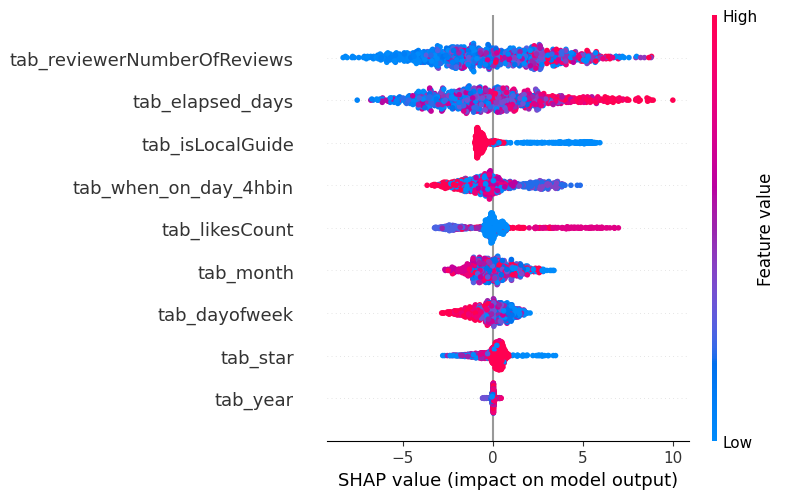

In [6]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import shap

train_df = pd.read_csv('detection_train.csv')
val_df = pd.read_csv('detection_val.csv')
test_df = pd.read_csv('detection_test.csv')

used_features = train_df.filter(regex='^(tab_)').columns
print(used_features)
print(used_features.dtype)


X_train, y_train = train_df[used_features], train_df['label']
print(X_train.head(10))
X_val, y_val = val_df[used_features], val_df['label']
X_test, y_test = test_df[used_features], test_df['label']

xgb = XGBClassifier(random_state=1, max_depth=3, n_estimators=3000)
xgb.fit(X_train, y_train)

y_pred_val = xgb.predict(X_val)
y_pred_test = xgb.predict(X_test)


accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Validation set accuracy: {accuracy_val}")
print(f"Test set accuracy: {accuracy_test}")


from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

f1 = f1_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val)
recall = recall_score(y_val, y_pred_val)
confusion = confusion_matrix(y_val, y_pred_val)

print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion matrix:\n{confusion}")
print(f"________________________________________________________________________")

import seaborn as sns
import matplotlib.pyplot as plt
import shap

X_train = X_train.dropna()
X_test = X_test.dropna()
X_val = X_val.dropna()

explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values, max_display=10,show=False) 
plt.tight_layout()
plt.savefig('shap_tab_xgb.svg', format='svg', dpi=1200)

# Tabular

# Image

# Multimodal